In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.signal import find_peaks, peak_prominences
from scipy.stats import entropy
import torch
import time
from sbi.inference.base import infer
from sbi import inference
import sbi.utils as utils
from scipy import stats as spstats
from scipy.stats import moment
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import mode
import seaborn as sns
from numba import jit

In [2]:

def m_inf(v):
    return 1.0 / (1.0 + np.exp((-24.0 - v) / 12.0))


def n_inf(v):
    return 1.0 / (1.0 + np.exp((-19.0 - v) / 18.0))


def h(n):
    return 1.1 - 1.0 / (1.0 + np.exp(-8.0 * (n - 0.4)))

def model(z, Kb, g_Cl = 7.5, g_Na = 40.0, g_K = 22.0, g_Nal = 0.02, g_Kl = 0.12,gamma = 0.04,epsilon = 0.01):
    # -------------------------------------------------------------
    Cm = 1.0
    tau_n = 0.25
    # -------------------------------------------------------------
    w_i = 2160.
    w_o = 720.

    rho = 250.
    beta = w_i / w_o

    K_bath = Kb

    Na_i0 = 16.0
    Na_o0 = 138.0
    K_i0 = 140.0
    K_o0 = 4.80
    Cl_o0 = 112.0
    Cl_i0 = 5.0
    # -------------------------------------------------------------

    V = z[0]
    n = z[1]
    DK_i = z[2]
    Kg = z[3]

    DNa_i = -DK_i
    DNa_o = -beta * DNa_i
    DK_o = -beta * DK_i
    K_i = K_i0 + DK_i
    Na_i = Na_i0 + DNa_i
    Na_o = Na_o0 + DNa_o
    K_o = K_o0 + DK_o + Kg
    I_Na = (g_Nal + g_Na * m_inf(V) * h(n)) * (V - 26.64 * np.log(Na_o / Na_i))
    I_K = (g_Kl + g_K * n) * (V - 26.64 * np.log(K_o / K_i))
    I_Cl = g_Cl * (V + 26.64 * np.log(Cl_o0 / Cl_i0))
    I_pump = rho * (1.0 / (1.0 + np.exp((21.0 - Na_i) / 2.0))) * (1.0 / (1.0 + np.exp((5.5 - K_o))))




    dV = (-1.0 / Cm) * (I_Cl + I_Na + I_K + I_pump)
    dn = (n_inf(V) - n) / tau_n
    dKi = -(gamma / w_i) * (I_K - 2.0 * I_pump)
    dKg = epsilon * (K_bath - K_o)

    dz = [dV, dn, dKi, dKg]

    return dz



In [3]:
def reverser(v):
    rev = {}
    for i in range(0,len(v)):
        rev[str(v[i])] = i
    return rev

In [4]:
def events_counter(w,th):
    v = reverser(w)
    burst = {}
    n_burst = 0
    burst['0'] = []
    burst['0'].append(w[0])
    for i in range(1,len(w)):
        der = abs(v[str(w[i])]-v[str(w[i-1])])/abs(w[i]-w[i-1])
        if der < th:
            n_burst += 1
            burst[str(n_burst)] = []
        burst[str(n_burst)].append(w[i])
    return burst

In [5]:
def one_burst_selector(burst,N):
    if len(burst) == 0:
        return 0
    elif burst[-1] >= 3*N/4:
        return 100000
    else:
        return 0

In [6]:
def peaks_reveal(v,peak_pos):
    peaks = []
    for i in peak_pos:
        peaks.append(v[int(i)])
    return np.array(peaks)

In [7]:
def bin_peaks(v,events,mode = 'binary'):
    v_bin = []
    peak_pos = []
    for Burst in events:
        peak_pos.extend(list(events[Burst]))
    minlength = min(peaks_reveal(v,peak_pos))
    for i in range(0,len(v)):
        if v[i] >= minlength:
            v_bin.append(1)
        else:
            v_bin.append(0)
    v_bin = np.array(v_bin)
    if mode == 'binary':
        return np.bincount(v_bin)
    elif mode == 'bin_plot':
        return v_bin

In [8]:
def features_bursts(events,z):
    tau_ave_burst = {}
    tau_var_burst = {}
    tau_slope_burst = {}
    amp_ave_burst = {}
    amp_var_burst = {}
    amp_slope_burst = {}
    for Burst in events:
        tau_ave_burst[str(Burst)] = np.average(events[str(Burst)])
        tau_var_burst[str(Burst)] = np.var(events[str(Burst)])/len(events[str(Burst)])
        slope = (events[str(Burst)][-1]-events[str(Burst)][0])/len(events[str(Burst)])
        if abs(slope) < 0.1:
            tau_slope_burst[str(Burst)] = 0
        elif slope > 0:
            tau_slope_burst[str(Burst)] = 1
        else:
            tau_slope_burst[str(Burst)] = -1
        amp = np.array([z[int(i)] for i in events[str(Burst)]])
        amp_ave_burst[str(Burst)] = np.average(amp)
        amp_var_burst[str(Burst)] = np.var(amp)/len(events[str(Burst)])
        slope = (amp[-1]-amp[0])/(events[str(Burst)][-1]-events[str(Burst)][0])
        if abs(slope) < 0.1:
            amp_slope_burst[str(Burst)] = 0
        elif slope > 0:
            amp_slope_burst[str(Burst)] = 1
        else:
            amp_slope_burst[str(Burst)] = -1
    return tau_ave_burst, tau_var_burst, amp_ave_burst, amp_var_burst, tau_slope_burst, amp_slope_burst

In [9]:
def features_series(events,z):
    f = features_bursts(events,z)
    ave_on_serie_tau = {}
    var_on_serie_tau = {}
    ave_on_serie_amp = {}
    var_on_serie_amp = {}   
    ISI_ave_serie = {}
    ISI_var_serie = {}
    S = {}
    Num_of_spikes = {}
    Num_burst = {}
    ave_on_serie_tau = 0
    var_on_serie_tau = 0
    ave_on_serie_amp = 0
    var_on_serie_amp = 0
    Tau = []
    if len(events) == 1:
        ISI_ave_serie = one_burst_selector(burst=events['0'],N = len(z))
        ISI_var_serie = 0
    else:
        for Burst in events:
            if int(Burst) < len(events)-1:
                Tau.append(events[str(int(Burst)+1)][0]-events[str(Burst)][-1])
        Tau = np.array(Tau)
        ISI_ave_serie = np.average(Tau)
        ISI_var_serie = np.var(Tau)
    binary_arr = bin_peaks(z,events)
    en = entropy(binary_arr, base = 10)/len(z)
    S = en
    Num_of_spikes = 0
    for Burst in events:
        ave_on_serie_tau += f[0][str(Burst)]/(len(events))
        var_on_serie_tau += f[1][str(Burst)]/(len(events))
        ave_on_serie_amp += f[2][str(Burst)]/(len(events))
        var_on_serie_amp += f[3][str(Burst)]/(len(events))
        Num_of_spikes += len(events[str(Burst)])/len(z)
        Num_burst = len(events)/len(z)
    features = np.array([ave_on_serie_tau,var_on_serie_tau,ave_on_serie_amp,var_on_serie_amp,ISI_ave_serie, ISI_var_serie, Num_burst, Num_of_spikes, S])
    return features

In [10]:
def calculate_summary_statistics(v,th):
    events = events_counter(v,th)
    return features_series(events,v)

In [11]:
def _Damien_model(params,ts,dt,gamma = 0.04,epsilon = 0.01):
    v_0 = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
    z0 = [-78.0, n_inf, -0.6, 0.8]
    Np = 10000
    t = np.linspace(0, Np, int(Np / 0.01))
    v = np.zeros_like(t)
    n = np.zeros_like(t)
    DK_i =  np.zeros_like(t)
    Kg =  np.zeros_like(t)
    Cm = 1.0
    tau_n = 0.25
    # -------------------------------------------------------------
    w_i = 2160.
    w_o = 720.

    rho = 250.
    beta = w_i / w_o

    K_bath = params

    Na_i0 = 16.0
    Na_o0 = 138.0
    K_i0 = 140.0
    K_o0 = 4.80
    Cl_o0 = 112.0
    Cl_i0 = 5.0
    g_Cl = 7.5
    g_Na = 40.0
    g_K = 22.0
    g_Nal = 0.02
    g_Kl = 0.12
    v[0] = z0[0]
    n[0] = z0[1]
    DK_i[0] = z0[2]
    Kg[0] =  z0[3]
    for i in range(1,ts.shape[0]):
        DNa_i = -DK_i[i-1]
        DNa_o = -beta * DNa_i
        DK_o = -beta * DK_i[i-1]
        K_i = K_i0 + DK_i[i-1]
        Na_i = Na_i0 + DNa_i
        Na_o = Na_o0 + DNa_o
        K_o = K_o0 + DK_o + Kg[i-1]
        
        m_inf =  1.0 / (1.0 + np.exp((-24.0 - v[i-1]) / 12.0))
        n_inf = 1.0 / (1.0 + np.exp((-19.0 - v[i-1]) / 18.0))
        h_n = 1.1 - 1.0 / (1.0 + np.exp(-8.0 * (n[i-1] - 0.4)))

        I_Na = (g_Nal + g_Na * m_inf * h_n) * (v[i-1] - 26.64 * np.log(Na_o / Na_i))
        I_K = (g_Kl + g_K * n[i-1]) * (v[i-1] - 26.64 * np.log(K_o / K_i))
        I_Cl = g_Cl * (v[i-1] + 26.64 * np.log(Cl_o0 / Cl_i0))
        I_pump = rho * (1.0 / (1.0 + np.exp((21.0 - Na_i) / 2.0))) * (1.0 / (1.0 + np.exp((5.5 - K_o))))

        dv = (-1.0 / Cm) * (I_Cl + I_Na + I_K + I_pump)
        dn = (n_inf - n[i-1]) / tau_n
        dDK_i = -(gamma / w_i) * (I_K - 2.0 * I_pump)
        dKg = epsilon * (K_bath - K_o)

        #dv, dn ,dki, dkg = model(z0,params)
        v[i] = v[i-1] + dt * dv
        n[i] = n[i-1] + dt * dn
        DK_i[i] = DK_i[i-1] + dt * dDK_i
        Kg[i] = Kg[i-1] + dt * dKg
    return np.concatenate((np.array(v).reshape(-1), np.array(n).reshape(-1),np.array(DK_i).reshape(-1),np.array(Kg).reshape(-1)))

In [12]:
@jit(nopython=True)
def ode_Damien_model(params):
    t_init = 0
    t_final = 10000
    dt = 0.01
    gamma=0.04
    epsilon=0.01
    ts = np.arange(t_init,t_final,dt)
    v_0 = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
    z0 = np.array([-78.0, n_inf, -0.6, 0.8])
    Np = 10000
    t = np.linspace(0, Np, int(Np / 0.01))
    v = np.zeros_like(t)
    n = np.zeros_like(t)
    DK_i = np.zeros_like(t)
    Kg = np.zeros_like(t)
    Cm = 1.0
    tau_n = 0.25

    w_i = 2160.
    w_o = 720.
    rho = 250.
    beta = w_i / w_o

    K_bath = params

    Na_i0 = 16.0
    Na_o0 = 138.0
    K_i0 = 140.0
    K_o0 = 4.80
    Cl_o0 = 112.0
    Cl_i0 = 5.0
    g_Cl = 7.5
    g_Na = 40.0
    g_K = 22.0
    g_Nal = 0.02
    g_Kl = 0.12
    v[0] = z0[0]
    n[0] = z0[1]
    DK_i[0] = z0[2]
    Kg[0] = z0[3]

    for i in range(1, ts.shape[0]):
        DNa_i = -DK_i[i - 1]
        DNa_o = -beta * DNa_i
        DK_o = -beta * DK_i[i - 1]
        K_i = K_i0 + DK_i[i - 1]
        Na_i = Na_i0 + DNa_i
        Na_o = Na_o0 + DNa_o
        K_o = K_o0 + DK_o + Kg[i - 1]

        m_inf = 1.0 / (1.0 + np.exp((-24.0 - v[i - 1]) / 12.0))
        n_inf = 1.0 / (1.0 + np.exp((-19.0 - v[i - 1]) / 18.0))
        h_n = 1.1 - 1.0 / (1.0 + np.exp(-8.0 * (n[i - 1] - 0.4)))

        I_Na = (g_Nal + g_Na * m_inf * h_n) * (v[i - 1] - 26.64 * np.log(Na_o / Na_i))
        I_K = (g_Kl + g_K * n[i - 1]) * (v[i - 1] - 26.64 * np.log(K_o / K_i))
        I_Cl = g_Cl * (v[i - 1] + 26.64 * np.log(Cl_o0 / Cl_i0))
        I_pump = rho * (1.0 / (1.0 + np.exp((21.0 - Na_i) / 2.0))) * (1.0 / (1.0 + np.exp((5.5 - K_o))))

        dv = (-1.0 / Cm) * (I_Cl + I_Na + I_K + I_pump)
        dn = (n_inf - n[i - 1]) / tau_n
        dDK_i = -(gamma / w_i) * (I_K - 2.0 * I_pump)
        dKg = epsilon * (K_bath - K_o)

        v[i] = v[i - 1] + dt * dv
        n[i] = n[i - 1] + dt * dn
        DK_i[i] = DK_i[i - 1] + dt * dDK_i
        Kg[i] = Kg[i - 1] + dt * dKg

    return np.concatenate((v, n, DK_i, Kg))


In [12]:
ode_Damien_model = jit(_Damien_model)

In [13]:
def Damien_model_Wrapper(params):

    params_ = np.asarray(params)
    V = -78.0
    n_inf = 1.0 / (1.0 + np.exp((-19.0 - V) / 18.0))
    z0 = np.array([V, n_inf, -0.6, 0.8])
    t_init = 0
    t_final = 10000
    dt = 0.01
    
    ts = np.arange(t_init,t_final,dt)
    nt=ts.shape[0]

    v = ode_Damien_model(params_[0])[0:nt]#,ts,dt)[0:nt]
    
    summstats = torch.as_tensor(calculate_summary_statistics(v.reshape(-1), th= 0.00012))
    
    return summstats

In [14]:
prior_min = [4]
prior_max = [25.0]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

In [15]:
prior.sample()   



tensor([20.2419])

In [16]:
prior.sample().tolist()

[5.767617225646973]

In [17]:
prior_samples=np.stack([prior.sample().tolist() for _ in range(1000)], axis=0)
prior_samples.shape

(1000, 1)

In [18]:
num_params=prior.sample().shape[0]
num_params

1

In [19]:
num_sims=10


In [20]:
start_time = time.time()
posterior = infer(Damien_model_Wrapper, prior, method='SNPE', num_simulations=num_sims, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 127 epochs.------------------------------------------------------------
--- 32.46448588371277 seconds ---


In [ ]:
params_label=np.array(['$\K$'])

Plot the membrane potential v and firing rate r

In [ ]:
v_0 = -78.0
n_inf = 1.0 / (1.0 + np.exp((-19.0 - v_0) / 18.0))
z0 = [-78.0, n_inf, -0.6, 0.8]
t_init = 0
t_final = 10000
dt = 0.01
ts = np.arange(t_init,t_final,dt)
nt=ts.shape[0]
K_true=7.5
true_params = np.array([K_true])

In [ ]:
x_obs = ode_Damien_model(true_params[0])
v_obs=x_obs[0:nt]
r_obs=x_obs[nt:2*nt]
x_obs_summary_statistics=calculate_summary_statistics(v_obs.reshape(-1), th= 0.00012)

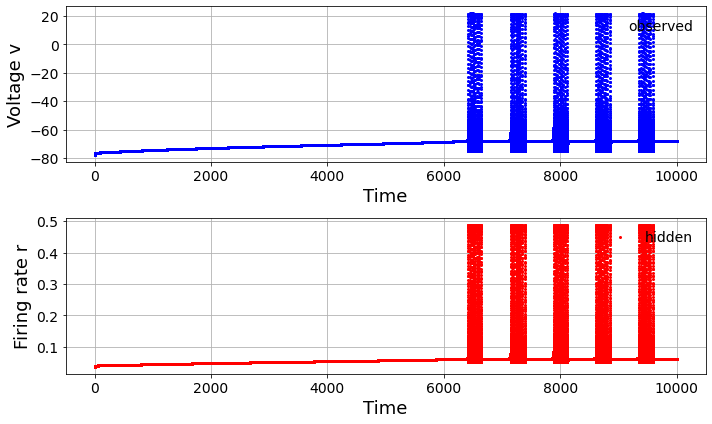

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
plt.plot(ts, v_obs, '.',  markersize=4, color='blue', label='observed')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Voltage v', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right',fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()

plt.subplot(212)
plt.plot(ts, r_obs, '.',  markersize=4, color='red',label='hidden')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Firing rate r',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.tight_layout()
plt.grid()
plt.show()

POSTERIOR SAMPLING

In [340]:
num_samples=10000

In [341]:
start_time = time.time()

posterior_samples = posterior.sample((num_samples,), x_obs_summary_statistics).numpy()

print ("-"*60)
print("--- posterior sampling took: %s seconds ---" % (time.time() - start_time))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

------------------------------------------------------------
--- posterior sampling took: 0.07731890678405762 seconds ---


In [342]:
posterior_samples.shape

(10000, 1)

In [343]:
K_est=posterior_samples[:,0]

In [344]:
print("K_est=", K_est.mean())

K_est= 6.703111


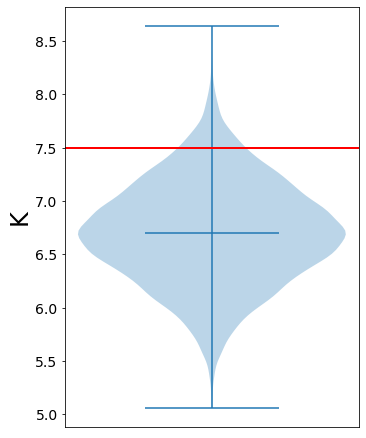

In [345]:
plt.figure(figsize=(5, 6))
for i, variables in enumerate([K_est]):
    plt.subplot(1,params_label.shape[0],i+1)
    plt.violinplot(variables, widths=0.7, showmeans=True, showextrema=True);
    plt.axhline(y=true_params[i], linewidth=2, color='r')
    plt.ylabel('K', fontsize=24)   
    plt.xticks([])
    plt.yticks(fontsize=14)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

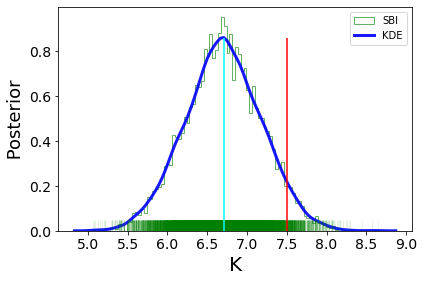

In [346]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=True, kde=True, rug=True, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 1, "alpha": 0.6, "color": "g"},
                  label='SBI')

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel('K', fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.show()

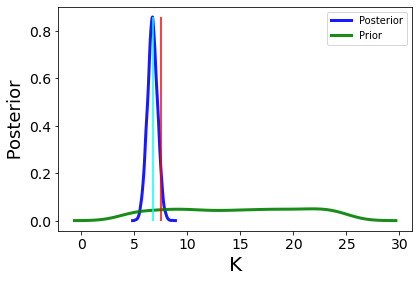

In [347]:
plt.figure(figsize=(16, 4))

for i in range (num_params): 
    ax = plt.subplot(1, 3, i + 1)
    
   
    ax=sns.distplot(posterior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "b", "alpha": 0.9, "lw": 3, "label": "Posterior"})
    
    ax_=sns.distplot(prior_samples[:,i], bins=100, hist=False, kde=True, rug=False, rug_kws={"alpha": 0.1, "color": "g"},
                  kde_kws={"color": "g", "alpha": 0.9, "lw": 3, "label": "Prior"})

    x_ = ax.lines[0].get_xdata()
    y_ = ax.lines[0].get_ydata()
    ymax = max(y_)
    xpos = np.argmax(y_, axis=0)
    xmax = x_[xpos]
    plt.vlines(x=xmax, ymin=0., ymax=y_.max(), colors='cyan', label='MAP')
    plt.vlines(x=true_params[i], ymin=0., ymax=y_.max(), colors='r', label='Truth')

    plt.xlabel('K', fontsize=20)   
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    if i==0:
        plt.ylabel(' Posterior ', fontsize=18);  
    else:
        plt.ylabel('')
        
    if i==2:
            plt.legend(fontsize=16, frameon=False)
 
plt.tight_layout(pad=1.0)
plt.show()